In [1]:
import numpy as np
import tensorflow as tf
import mdn
import time

In [2]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Attention
from tensorflow.keras.layers import (Conv2D, Input, Reshape, 
                                     Lambda, Dense, Conv2DTranspose)

if tf.test.is_gpu_available():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import matplotlib.pyplot as plt
import os
import utils

from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                       TensorBoard, Callback)
import datetime
from utils import TrainTimeCallback

In [4]:
import matplotlib.pyplot as plt

In [5]:
import models

In [6]:
from tqdm import tqdm

In [7]:
seq_len = 128
act_len = 3
n_mixtures = 5
output_dims = 32

In [8]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          24054        3371        2588         126       18094       20161
Swap:           975           6         969


In [9]:
def load_folder(path, files):
    #files = os.listdir(path)
    _1 = np.load(os.path.join(path, files[0]))
    data = np.zeros((len(files), *_1.shape))
    for i, fname in enumerate(tqdm(files)):
        data[i] = np.load(os.path.join(path, fname))
    return data

In [10]:
z_files = [f'z_state{i}_{j}.npy' for i in range(500) for j in range(3*128)]

a_files = [f'action{i}_{j}.npy' for i in range(500) for j in range(3*128)]

In [11]:
z_states = load_folder('./sausage/z_states', z_files)

100%|██████████| 192000/192000 [00:40<00:00, 4734.82it/s]


In [12]:
actions = load_folder('./sausage/actions', a_files)

100%|██████████| 192000/192000 [00:40<00:00, 4774.76it/s]


In [13]:
pair = np.concatenate((z_states, actions), axis=1)

In [14]:
pair.shape

(192000, 35)

In [15]:
latent_dataset = tf.data.Dataset.from_tensor_slices(pair)

In [16]:
sequences = latent_dataset.batch(seq_len + 1, drop_remainder=True)

In [17]:
sequences

<BatchDataset shapes: (129, 35), types: tf.float64>

In [18]:
def split_input_target(chunk):
    input_z = chunk[:-1]
    target_z = chunk[1:, :32]
    return input_z, target_z

In [19]:
dataset = sequences.map(split_input_target)

In [20]:
dataset

<MapDataset shapes: ((128, 35), (128, 32)), types: (tf.float64, tf.float64)>

In [21]:
dataset = dataset.shuffle(10000).batch(utils.BATCH_SIZE, drop_remainder=True)

In [22]:
dataset

<BatchDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [23]:
i = 0
for a, b in dataset:
    i += 1

In [24]:
percent_20 = i // 5
val = dataset.take(percent_20)
train = dataset.skip(percent_20)

In [25]:
val

<TakeDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [26]:
train

<SkipDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [27]:
!mkdir "./logs/"
!mkdir "./logs/fit"
!rm "./logs/fit/*"

mkdir: cannot create directory ‘./logs/’: File exists
mkdir: cannot create directory ‘./logs/fit’: File exists
rm: cannot remove './logs/fit/*': No such file or directory


In [28]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [29]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.W1 = tf.keras.layers.Dense(units, input_shape=(35,))
        self.W2 = tf.keras.layers.Dense(units, input_shape=(256,))
        self.V = tf.keras.layers.Dense(1, input_shape=(256,))

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        # hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # 
        features = tf.expand_dims(features, 0)
        hidden = tf.expand_dims(hidden, 0)
        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        # context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
    def get_config(self):
        config = super(BahdanauAttention, self).get_config()
        config.update({
            'units':self.units
        })
        return config
    
    def from_config(cls, config):
        return cls(**config)
    

In [30]:
class attention_mdn_rnn(tf.keras.Model):
    def __init__(self, 
                seq_len=128, 
                act_len=3, 
                latent_size=32, 
                cells=256, 
                output_dim=32, 
                n_mixes=5):
        super(attention_mdn_rnn, self).__init__()

        
        self.seq_len=seq_len
        self.act_len=act_len
        self.latent_size=latent_size
        self.cells=cells
        self.output_dim=output_dim
        self.n_mixes=n_mixes
        
        #self.inputs = Input((None, self.act_len + self.latent_size))
        self.lstm   = LSTM(self.cells,
                            return_sequences=True,
                            return_state=True,
                            recurrent_initializer='glorot_uniform')

        self.attention = BahdanauAttention(self.cells)
        self.out       = mdn.MDN(self.output_dim, self.n_mixes)
        
    def call(self, x, hidden):

        context_vector, attention_weights = self.attention(x, hidden)
        #context_vector = context_vector.numpy().squeeze()
        
        # context_vector = features * attention_weights
        x, hidden_out, c = self.lstm(context_vector[0]) #remove 1 from input shape (1, x, y, z)
        x = self.out(x)
        
        return x, hidden_out#, attention_weights

    def get_config(self):
        config = super(attention_mdn_rnn, self).get_config()
        config.update({'seq_len':self.seq_len,
                        'act_len':self.act_len,
                        'latent_size':self.latent_size,
                        'cells':self.cells,
                        'output_dim':self.output_dim,
                        'n_mixes':self.n_mixes})
        return config

    def from_config(cls, config):
        return cls(**config)
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.cells))

In [31]:
M = attention_mdn_rnn()

In [32]:
loss_function = mdn.get_mixture_loss_func(32, 5)

In [33]:
optimizer = tf.keras.optimizers.Adam()

In [34]:
loss_plot = []

In [35]:
num_mixes = 5
output_dim = 32

In [36]:
@tf.function
def train_step(pair, target):
    loss = 0
    hidden = M.reset_state(128)

    with tf.GradientTape() as tape:
        z, hidden = M(pair, hidden)
        
        try:
            loss += loss_function(target, z)
        except Exception as e:
            import pdb; pdb.set_trace()
    
    
    total_loss = (loss / int(target.shape[1]))

    trainable_variables = M.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [37]:
start_epoch = 0

In [38]:
tf.keras.backend.set_floatx('float64')

In [39]:
val_loss = []

In [40]:
EPOCHS = 700

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (z_tensor, target)) in enumerate(train):
        batch_loss, t_loss = train_step(z_tensor, target)
        total_loss += t_loss
        
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / i)

    for (batch, (z_tensor, target)) in enumerate(val):
        batch_loss, t_loss = train_step(z_tensor, target)
        total_loss += t_loss
        
    val_loss.append(total_loss / i)

  0%|          | 0/700 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

100%|██████████| 700/700 [10:29<00:00,  1.11it/s]


In [44]:
M.save_weights('./weights/2019.12.07/attn_mdn_rnn', save_format='tf') 

In [45]:
M.load_weights('./weights/2019.12.07/attn_mdn_rnn')

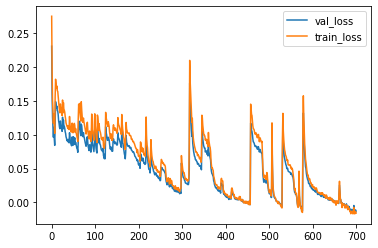

In [46]:
plt.plot(loss_plot, label='val_loss')
plt.plot(val_loss, label='train_loss')
plt.legend(loc='best')